In [105]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [106]:
# Load MATLAB files
data_dir = 'Data'
files = ['FB (Amit - OpenField_4ch)_new.mat', 
         'FG (Amit - OpenField_4ch)_new.mat',
         'FR (Amit - OpenField_4ch)_new.mat',
         'FW (Amit - OpenField_4ch)_new.mat',
         'MB (Amit - OpenField_4ch)_new.mat',
         'MG (Amit - OpenField_4ch)_new.mat',
         'MR (Amit - OpenField_4ch)_new.mat',
         'MW (Amit - OpenField_4ch)_new.mat']

# Load each file
data = {}
for file in files:
    file_path = os.path.join(data_dir, file)
    key = file.split()[0]  # Extract animal ID (FB, FG, FR, FW, MB, MG, MR, MW)
    data[key] = scipy.io.loadmat(file_path)
    print(f"Loaded {key}: {list(data[key].keys())}")

Loaded FB: ['__header__', '__version__', '__globals__', 'Freezing_start_stop', 'crossing_times', 'grooming_start_stop', 'periphery_times']
Loaded FG: ['__header__', '__version__', '__globals__', 'Freezing_start_stop', 'crossing_times', 'grooming_start_stop', 'periphery_times']
Loaded FR: ['__header__', '__version__', '__globals__', 'Freezing_start_stop', 'crossing_times', 'grooming_start_stop', 'periphery_times']
Loaded FW: ['__header__', '__version__', '__globals__', 'Freezing_start_stop', 'crossing_times', 'grooming_start_stop', 'periphery_times']
Loaded MB: ['__header__', '__version__', '__globals__', 'Freezing_start_stop', 'crossing_times', 'grooming_start_stop', 'periphery_times']
Loaded MG: ['__header__', '__version__', '__globals__', 'Freezing_start_stop', 'crossing_times', 'grooming_start_stop', 'periphery_times']
Loaded MR: ['__header__', '__version__', '__globals__', 'Freezing_start_stop', 'crossing_times', 'grooming_start_stop', 'periphery_times']
Loaded MW: ['__header__', '

In [107]:
def get_events_in_bin(events, bin_start, bin_end, total_duration=600):
    """
    Filter events to only include those in the specified time bin.
    Adjusts timestamps to use the last 600 seconds if data is longer.
    
    events: array of timestamps or start/stop pairs
    bin_start, bin_end: time range for this bin
    total_duration: total duration to use (600 seconds)
    """
    if events.size == 0:
        return events
    
    # Determine offset if data exceeds 600 seconds
    max_time = np.max(events)
    offset = max_time - total_duration if max_time > total_duration else 0
    
    # Adjust events by offset
    events_adjusted = events - offset
    
    # Handle different data structures
    if events.shape[0] == 2:
        # Start/stop format: row 0 = starts, row 1 = stops
        starts = events_adjusted[0, :]
        stops = events_adjusted[1, :]
        
        # Find events that overlap with bin
        mask = (starts <= bin_end) & (stops >= bin_start)
        filtered_starts = np.maximum(starts[mask], bin_start)
        filtered_stops = np.minimum(stops[mask], bin_end)
        
        return np.array([filtered_starts, filtered_stops])
    else:
        # Single row of timestamps
        events_flat = events_adjusted.flatten()
        mask = (events_flat >= bin_start) & (events_flat <= bin_end)
        return events_flat[mask]


In [108]:
# Process data into 4 bins (150 seconds each)
total_duration = 600  # Total experiment duration in seconds
bin_duration = total_duration / 4  # 150 seconds per bin
bins = [(i * bin_duration, (i + 1) * bin_duration) for i in range(4)]

print(f"Time bins (seconds): {bins}")

# Process each animal's data into bins
binned_data = {}
for animal in data.keys():
    if animal.startswith('__'):
        continue
    
    print(f"\nProcessing {animal}...")
    binned_data[animal] = {}
    
    for i, (bin_start, bin_end) in enumerate(bins):
        bin_label = f"Bin_{i+1}"
        binned_data[animal][bin_label] = {}
        
        # Process each behavior
        for behavior in ['Freezing_start_stop', 'crossing_times', 'grooming_start_stop', 'periphery_times']:
            if behavior in data[animal]:
                events = data[animal][behavior]
                binned_events = get_events_in_bin(events, bin_start, bin_end)
                binned_data[animal][bin_label][behavior] = binned_events
                
                # Calculate duration or count
                if behavior.endswith('_start_stop'):
                    # For start/stop format (2 rows)
                    if binned_events.size > 0 and binned_events.shape[0] == 2:
                        duration = np.sum(binned_events[1, :] - binned_events[0, :])
                    else:
                        duration = 0
                    print(f"  {bin_label} - {behavior}: {duration:.2f}s")
                else:
                    # For timestamp arrays
                    count = len(binned_events)
                    print(f"  {bin_label} - {behavior}: {count} events")
        
        # Calculate center events (crossing events - periphery events)
        crossing_count = len(binned_data[animal][bin_label]['crossing_times'])
        periphery_count = len(binned_data[animal][bin_label]['periphery_times'])
        center_count = crossing_count - periphery_count
        binned_data[animal][bin_label]['center_count'] = center_count
        print(f"  {bin_label} - center_count: {center_count} events")


Time bins (seconds): [(0.0, 150.0), (150.0, 300.0), (300.0, 450.0), (450.0, 600.0)]

Processing FB...
  Bin_1 - Freezing_start_stop: 3.73s
  Bin_1 - crossing_times: 113 events
  Bin_1 - grooming_start_stop: 0.75s
  Bin_1 - periphery_times: 87 events
  Bin_1 - center_count: 26 events
  Bin_2 - Freezing_start_stop: 1.51s
  Bin_2 - crossing_times: 73 events
  Bin_2 - grooming_start_stop: 9.73s
  Bin_2 - periphery_times: 50 events
  Bin_2 - center_count: 23 events
  Bin_3 - Freezing_start_stop: 0.32s
  Bin_3 - crossing_times: 64 events
  Bin_3 - grooming_start_stop: 2.72s
  Bin_3 - periphery_times: 43 events
  Bin_3 - center_count: 21 events
  Bin_4 - Freezing_start_stop: 0.44s
  Bin_4 - crossing_times: 94 events
  Bin_4 - grooming_start_stop: 2.78s
  Bin_4 - periphery_times: 64 events
  Bin_4 - center_count: 30 events

Processing FG...
  Bin_1 - Freezing_start_stop: 6.28s
  Bin_1 - crossing_times: 100 events
  Bin_1 - grooming_start_stop: 0.66s
  Bin_1 - periphery_times: 70 events
  Bin_1

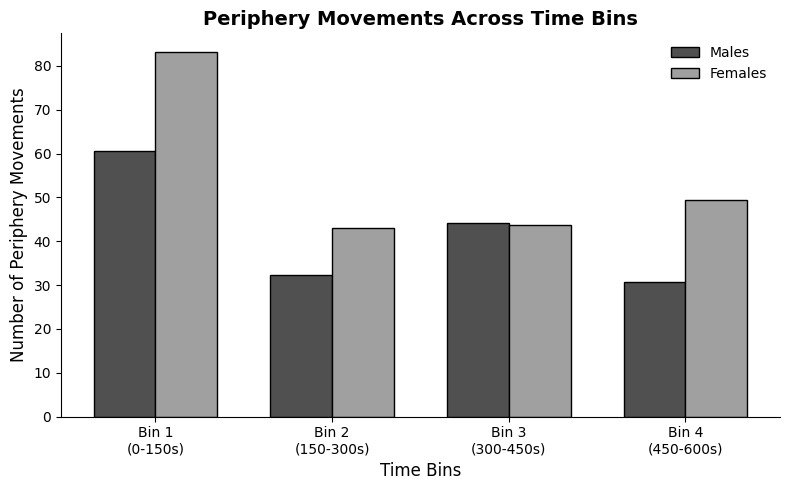


Periphery movement counts by sex:
Males: [np.float64(60.5), np.float64(32.25), np.float64(44.25), np.float64(30.75)]
Females: [np.float64(83.25), np.float64(43.0), np.float64(43.75), np.float64(49.5)]
Males: [np.float64(60.5), np.float64(32.25), np.float64(44.25), np.float64(30.75)]
Females: [np.float64(83.25), np.float64(43.0), np.float64(43.75), np.float64(49.5)]


In [109]:
def plot_periphery_histogram(binned_data, sex_groups):
    """
    Create a histogram showing the average number of periphery movements across bins by sex.
    
    Parameters:
    binned_data: dictionary containing binned behavioral data for all animals
    sex_groups: dictionary grouping animals by sex
    """
    bin_labels = ['Bin 1\n(0-150s)', 'Bin 2\n(150-300s)', 'Bin 3\n(300-450s)', 'Bin 4\n(450-600s)']
    
    # Collect data by sex
    sex_data = {}
    for sex, animals in sex_groups.items():
        sex_data[sex] = []
        for i in range(1, 5):
            bin_key = f'Bin_{i}'
            bin_counts = []
            for animal in animals:
                periphery_data = binned_data[animal][bin_key]['periphery_times']
                count = len(periphery_data) if periphery_data.size > 0 else 0
                bin_counts.append(count)
            sex_data[sex].append(np.mean(bin_counts))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    x = np.arange(len(bin_labels))
    width = 0.35
    
    # Plot bars for each sex
    ax.bar(x - width/2, sex_data['Males'], width, label='Males', color='#505050', edgecolor='black')
    ax.bar(x + width/2, sex_data['Females'], width, label='Females', color='#A0A0A0', edgecolor='black')
    
    # Customize the plot
    ax.set_xlabel('Time Bins', fontsize=12)
    ax.set_ylabel('Number of Periphery Movements', fontsize=12)
    ax.set_title('Periphery Movements Across Time Bins', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(bin_labels)
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return sex_data
periphery_counts = plot_periphery_histogram(binned_data, sex_groups)
print("\nPeriphery movement counts by sex:")
for sex, counts in periphery_counts.items():
    print(f"{sex}: {counts}")
for animal, counts in periphery_counts.items():

    print(f"{animal}: {counts}")

In [110]:
# Organize animals by sex
# F prefix = Females, M prefix = Males
sex_groups = {
    'Males': ['MB', 'MG', 'MR', 'MW'],
    'Females': ['FB', 'FG', 'FR', 'FW']
}

print("Animal groupings:")
for sex, animals in sex_groups.items():
    print(f"{sex}: {animals}")

Animal groupings:
Males: ['MB', 'MG', 'MR', 'MW']
Females: ['FB', 'FG', 'FR', 'FW']


Males mean cumulative crossings: [109.25 166.5  238.25 297.  ]
Females mean cumulative crossings: [114.25 186.   263.75 354.5 ]


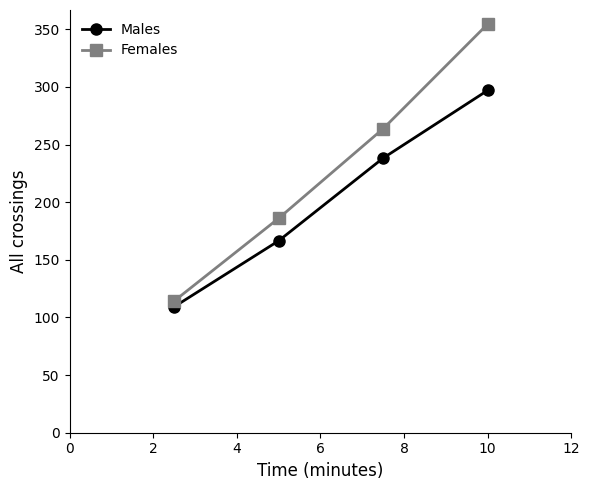

In [120]:
# Chart A: All crossings over time (Males vs Females)
def plot_all_crossings(binned_data, sex_groups):
    """
    Plot total crossings (periphery + center) across time bins for males and females.
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    
    time_points = [2.5, 5.0, 7.5, 10.0]  # Midpoint of each bin in minutes
    
    for sex, animals in sex_groups.items():
        # Collect all individual animal data
        animal_data = []
        for animal in animals:
            crossings = []
            for i in range(1, 5):
                bin_key = f'Bin_{i}'
                crossing_count = len(binned_data[animal][bin_key]['crossing_times'])
                crossings.append(crossing_count)
            animal_data.append(crossings)
        
        # Convert to numpy array for easier manipulation
        animal_data = np.array(animal_data)
        
        # Calculate and plot mean
        cumulative_data = np.cumsum(animal_data, axis=1)
        mean_crossings = np.mean(cumulative_data, axis=0)
        
        marker = 'o' if sex == 'Males' else 's'
        color = 'black' if sex == 'Males' else 'gray'
        ax.plot(time_points, mean_crossings, marker=marker, color=color, 
               label=sex, linewidth=2, markersize=8, zorder=2)
        
        print(f"{sex} mean cumulative crossings: {mean_crossings}")
    
    ax.set_xlabel('Time (minutes)', fontsize=12)
    ax.set_ylabel('All crossings', fontsize=12)
    ax.set_xlim(0, 12)
    ax.set_ylim(0, None)  # Auto-scale y-axis
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_all_crossings(binned_data, sex_groups)

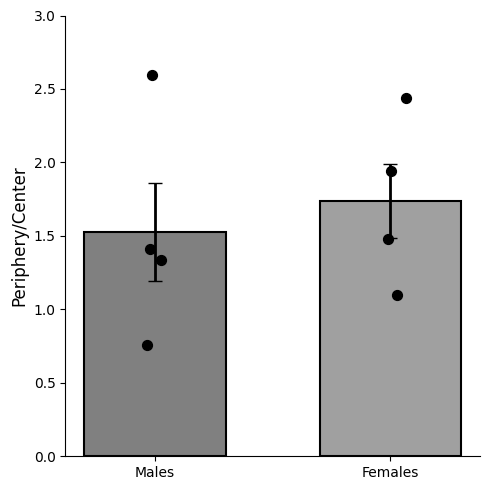


Periphery/Center ratios:
Males: 1.53 (individual: [1.3360655737704918, 1.4137931034482758, 0.7584541062801933, 2.5972222222222223])
Females: 1.74 (individual: [2.44, 1.944, 1.096938775510204, 1.4789915966386555])


In [112]:
# Chart B: Periphery/Center bar chart (Males vs Females)
def plot_periphery_center_ratio(binned_data, sex_groups):
    """
    Plot the ratio of periphery to center movements for males and females.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    
    ratios_by_sex = {}
    individual_ratios = {}
    
    for sex, animals in sex_groups.items():
        individual_ratios[sex] = []
        for animal in animals:
            total_periphery = 0
            total_center = 0
            for i in range(1, 5):
                bin_key = f'Bin_{i}'
                total_periphery += len(binned_data[animal][bin_key]['periphery_times'])
                total_center += binned_data[animal][bin_key]['center_count']
            
            if total_center > 0:
                ratio = total_periphery / total_center
                individual_ratios[sex].append(ratio)
        
        ratios_by_sex[sex] = np.mean(individual_ratios[sex])
    
    # Create bar plot
    x_pos = [0, 1]
    colors = ['#808080', '#A0A0A0']
    bars = ax.bar(x_pos, [ratios_by_sex['Males'], ratios_by_sex['Females']], 
                  color=colors, width=0.6, edgecolor='black', linewidth=1.5)
    
    # Add individual data points
    for i, sex in enumerate(['Males', 'Females']):
        x_jitter = np.random.normal(i, 0.04, size=len(individual_ratios[sex]))
        ax.scatter(x_jitter, individual_ratios[sex], color='black', s=50, zorder=3)
    
    # Add error bars (SEM)
    for i, sex in enumerate(['Males', 'Females']):
        sem = np.std(individual_ratios[sex]) / np.sqrt(len(individual_ratios[sex]))
        ax.errorbar(i, ratios_by_sex[sex], yerr=sem, color='black', 
                   capsize=5, linewidth=2, zorder=4)
    
    ax.set_ylabel('Periphery/Center', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Males', 'Females'])
    ax.set_ylim(0, 3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()
    
    return ratios_by_sex, individual_ratios

ratios_by_sex, individual_ratios = plot_periphery_center_ratio(binned_data, sex_groups)
print("\nPeriphery/Center ratios:")
for sex, ratio in ratios_by_sex.items():
    print(f"{sex}: {ratio:.2f} (individual: {individual_ratios[sex]})")

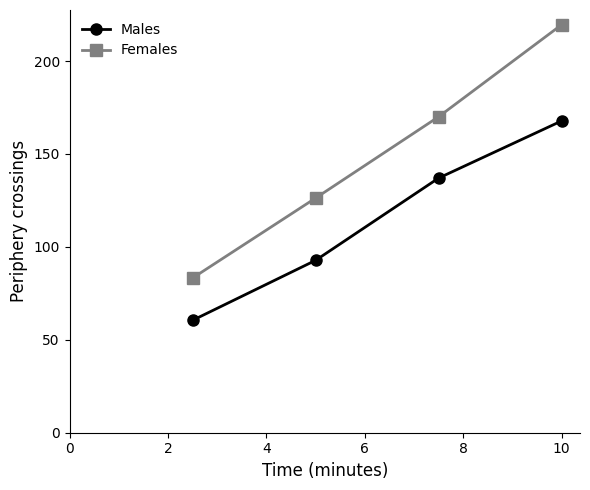

In [121]:
# Chart C: Periphery crossings over time (Males vs Females)
def plot_periphery_crossings(binned_data, sex_groups):
    """
    Plot periphery crossings across time bins for males and females.
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    
    time_points = [2.5, 5.0, 7.5, 10.0]  # Midpoint of each bin in minutes
    
    for sex, animals in sex_groups.items():
        # Collect all individual animal data
        animal_data = []
        for animal in animals:
            periphery = []
            for i in range(1, 5):
                bin_key = f'Bin_{i}'
                periphery_count = len(binned_data[animal][bin_key]['periphery_times'])
                periphery.append(periphery_count)
            animal_data.append(periphery)
        
        # Convert to numpy array
        animal_data = np.array(animal_data)
        
        # Calculate and plot mean
        cumulative_data = np.cumsum(animal_data, axis=1)
        mean_periphery = np.mean(cumulative_data, axis=0)
        
        marker = 'o' if sex == 'Males' else 's'
        color = 'black' if sex == 'Males' else 'gray'
        ax.plot(time_points, mean_periphery, marker=marker, color=color, 
               label=sex, linewidth=2, markersize=8, zorder=2)
    
    ax.set_xlabel('Time (minutes)', fontsize=12)
    ax.set_ylabel('Periphery crossings', fontsize=12)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_periphery_crossings(binned_data, sex_groups)

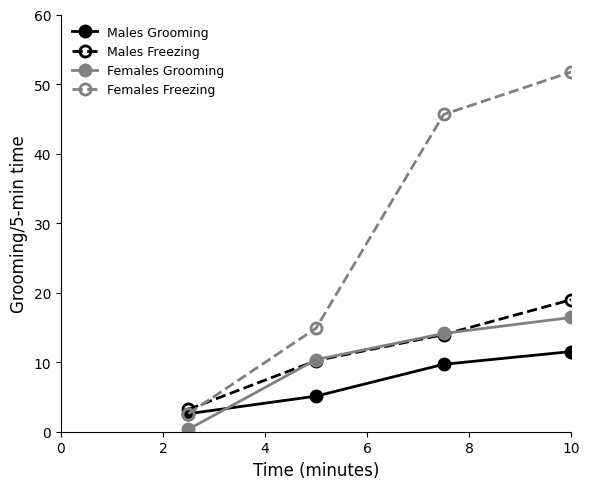

In [ ]:
# Chart D: Grooming and Freezing over time (Males vs Females, separate behaviors)
def plot_grooming_freezing(binned_data, sex_groups):
    """
    Plot grooming and freezing durations across time bins for males and females.
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    
    time_points = [2.5, 5.0, 7.5, 10.0]  # Midpoint of each bin in minutes
    
    # Define styles for each sex-behavior combination
    styles = {
        ('Females', 'Grooming'): {'marker': 'o', 'color': 'gray', 'linestyle': '-', 'fillstyle': 'full'},
        ('Males', 'Grooming'): {'marker': 'o', 'color': 'black', 'linestyle': '-', 'fillstyle': 'full'},
        ('Females', 'Freezing'): {'marker': 'o', 'color': 'gray', 'linestyle': '--', 'fillstyle': 'none'},
        ('Males', 'Freezing'): {'marker': 'o', 'color': 'black', 'linestyle': '--', 'fillstyle': 'none'},
    }
    
    for sex, animals in sex_groups.items():
        for behavior_type, behavior_key in [('Grooming', 'grooming_start_stop'), 
                                             ('Freezing', 'Freezing_start_stop')]:
            # Collect all individual animal data
            animal_data = []
            for animal in animals:
                durations = []
                for i in range(1, 5):
                    bin_key = f'Bin_{i}'
                    events = binned_data[animal][bin_key][behavior_key]
                    if events.size > 0 and events.shape[0] == 2:
                        duration = np.sum(events[1, :] - events[0, :])
                    else:
                        duration = 0
                    durations.append(duration)
                animal_data.append(durations)
            
            # Convert to numpy array
            animal_data = np.array(animal_data)
            
            # Calculate and plot mean
            cumulative_data = np.cumsum(animal_data, axis=1)
            mean_duration = np.mean(cumulative_data, axis=0)
            
            style = styles[(sex, behavior_type)]
            label = f"{sex} {behavior_type}"
            ax.plot(time_points, mean_duration, marker=style['marker'], 
                   color=style['color'], linestyle=style['linestyle'],
                   fillstyle=style['fillstyle'], label=label, linewidth=2, 
                   markersize=8, markeredgewidth=2, zorder=2)
    
    ax.set_xlabel('Time (minutes)', fontsize=12)
    ax.set_ylabel('Grooming/5-min time', fontsize=12)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 60)
    ax.legend(frameon=False, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_grooming_freezing(binned_data, sex_groups)

## Rotarod Analysis
Additional behavioral analysis charts

In [ ]:
# Load actual rotarod data from Excel file
rotarod_file = os.path.join(data_dir, 'Rotarod 031225.xlsx')
rotarod_df = pd.read_excel(rotarod_file)

# Clean column names (remove extra spaces)
rotarod_df.columns = rotarod_df.columns.str.strip()

# Filter for rows with valid subject IDs and clean them
rotarod_df = rotarod_df[rotarod_df['Subject ID'].notna()]
rotarod_df['Subject ID'] = rotarod_df['Subject ID'].str.strip()
rotarod_df = rotarod_df[rotarod_df['Subject ID'] != '']  # Remove empty strings

# Group by subject and create trial numbers
rotarod_data = {}
for subject in rotarod_df['Subject ID'].unique():
    subject_trials = rotarod_df[rotarod_df['Subject ID'] == subject]['Duration(sec)'].values
    rotarod_data[subject] = list(subject_trials)

print("Rotarod data by animal:")
for animal, trials in sorted(rotarod_data.items()):
    print(f"{animal}: {trials}")

# Calculate total crossings from open field data for correlation analysis
total_crossings = {}
for animal in binned_data.keys():
    total = sum(len(binned_data[animal][f'Bin_{i}']['crossing_times']) for i in range(1, 5))
    total_crossings[animal] = total

print("\nRotarod data processed successfully!")
print(f"Animals with rotarod data: {sorted(rotarod_data.keys())}")

Rotarod data by animal:
FB: [np.float64(77.0), np.float64(144.0), np.float64(124.0), np.float64(160.0), np.float64(94.0)]
FG: [np.float64(189.0), np.float64(201.0), np.float64(215.0), np.float64(193.0), np.float64(183.0)]
FR: [np.float64(167.0), np.float64(205.0), np.float64(189.0), np.float64(177.0), np.float64(143.0)]
FW: [np.float64(99.0), np.float64(16.0), np.float64(160.0), np.float64(167.0), np.float64(126.0)]
MB: [np.float64(38.0), np.float64(174.0), np.float64(159.0), np.float64(161.0), np.float64(164.0)]
MG: [np.float64(186.0), np.float64(194.0), np.float64(196.0), np.float64(218.0), np.float64(274.0)]
MR: [np.float64(174.0), np.float64(256.0), np.float64(223.0), np.float64(172.0), np.float64(167.0)]
MW: [np.float64(85.0), np.float64(231.0), np.float64(235.0), np.float64(205.0), np.float64(223.0)]

Rotarod data processed successfully!
Animals with rotarod data: ['FB', 'FG', 'FR', 'FW', 'MB', 'MG', 'MR', 'MW']


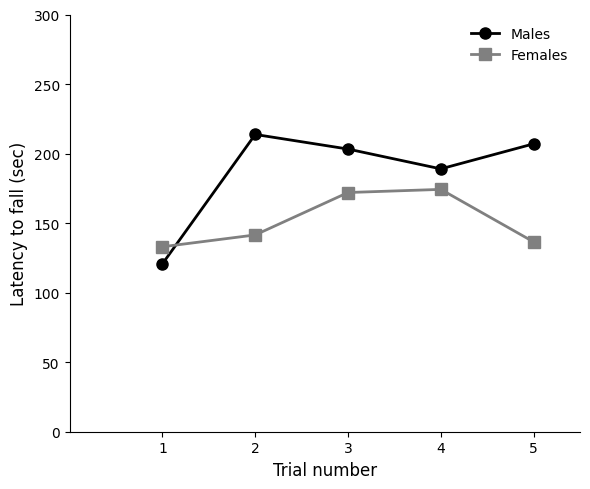

In [ ]:
# Figure 2A: Rotarod - Latency to fall across 5 trials
def plot_rotarod_latency(rotarod_data, sex_groups):
    """
    Plot latency to fall across 5 rotarod trials for males and females.
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    
    trials = [1, 2, 3, 4, 5]
    
    for sex, animals in sex_groups.items():
        # Collect data for each animal
        animal_data = []
        for animal in animals:
            if animal in rotarod_data:
                # Convert to float and ensure we have exactly 5 trials
                trials_data = [float(x) for x in rotarod_data[animal][:5]]
                animal_data.append(trials_data)
        
        if len(animal_data) == 0:
            continue
            
        animal_data = np.array(animal_data)
        
        # Calculate and plot mean
        mean_latency = np.mean(animal_data, axis=0)
        
        marker = 'o' if sex == 'Males' else 's'
        color = 'black' if sex == 'Males' else 'gray'
        ax.plot(trials, mean_latency, marker=marker, color=color, 
               label=sex, linewidth=2, markersize=8, zorder=2)
    
    ax.set_xlabel('Trial number', fontsize=12)
    ax.set_ylabel('Latency to fall (sec)', fontsize=12)
    ax.set_xlim(0, 5.5)
    ax.set_ylim(0, 300)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_rotarod_latency(rotarod_data, sex_groups)

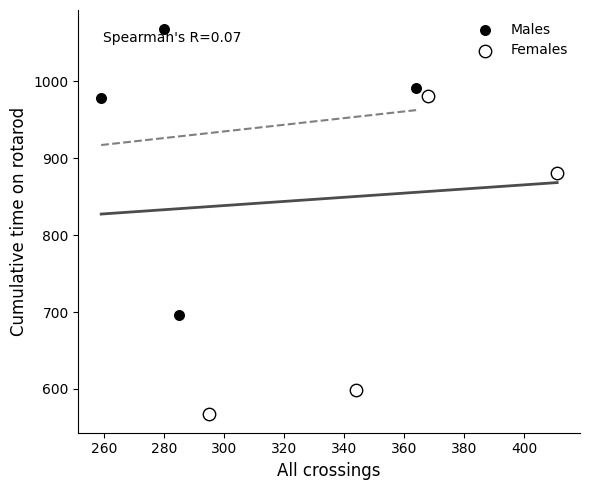


Correlation Analysis:
Spearman's R = 0.07
p-value = 0.8626


In [117]:
# Figure 2B: Correlation between crossings and cumulative latency
def plot_correlation_crossings_latency(rotarod_data, total_crossings, sex_groups):
    """
    Plot correlation between total crossings in open field and cumulative latency in rotarod.
    """
    from scipy import stats
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Calculate cumulative latency for each animal
    cumulative_latency = {animal: sum(latencies) for animal, latencies in rotarod_data.items()}
    
    # Prepare data for plotting
    males_crossings = [total_crossings[animal] for animal in sex_groups['Males']]
    males_latency = [cumulative_latency[animal] for animal in sex_groups['Males']]
    
    females_crossings = [total_crossings[animal] for animal in sex_groups['Females']]
    females_latency = [cumulative_latency[animal] for animal in sex_groups['Females']]
    
    # Plot data points
    ax.scatter(males_crossings, males_latency, color='black', s=80, 
              marker='o', label='Males', zorder=3, edgecolors='white', linewidths=1)
    ax.scatter(females_crossings, females_latency, color='white', s=80, 
              marker='o', label='Females', zorder=3, edgecolors='black', linewidths=1)
    
    # Calculate and plot regression lines
    all_crossings = males_crossings + females_crossings
    all_latency = males_latency + females_latency
    
    # Overall correlation
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_crossings, all_latency)
    x_line = np.array([min(all_crossings), max(all_crossings)])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'k-', linewidth=2, alpha=0.7, zorder=1)
    
    # Males regression (lighter line)
    slope_m, intercept_m, r_m, _, _ = stats.linregress(males_crossings, males_latency)
    x_line_m = np.array([min(males_crossings), max(males_crossings)])
    y_line_m = slope_m * x_line_m + intercept_m
    ax.plot(x_line_m, y_line_m, 'k--', linewidth=1.5, alpha=0.5, zorder=1)
    
    ax.set_xlabel('All crossings', fontsize=12)
    ax.set_ylabel('Cumulative time on rotarod', fontsize=12)
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add correlation text
    ax.text(0.05, 0.95, f"Spearman's R={r_value:.2f}", 
           transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCorrelation Analysis:")
    print(f"Spearman's R = {r_value:.2f}")
    print(f"p-value = {p_value:.4f}")

plot_correlation_crossings_latency(rotarod_data, total_crossings, sex_groups)

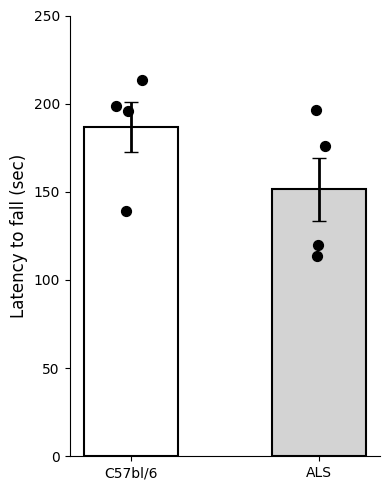


Genotype Comparison:
C57bl/6: 186.8 ± 14.1 sec
ALS: 151.4 ± 17.8 sec
t-test: t=1.35, p=0.2268
Significant: No


In [114]:
# Figure 3A: Bar chart comparing genotypes (C57BL/6 vs ALS model)
def plot_genotype_comparison(rotarod_data, sex_groups):
    """
    Bar chart comparing latency to fall between two genotypes.
    Assumes first 4 animals are C57BL/6 and second 4 are disease model.
    """
    from scipy import stats
    
    fig, ax = plt.subplots(figsize=(4, 5))
    
    # For this example, we'll treat Males as C57bl/6 and Females as ALS model
    # Replace with actual genotype groupings based on your experimental design
    genotype_groups = {
        'C57bl/6': sex_groups['Males'],  # Change this to match your actual groups
        'ALS': sex_groups['Females']      # Change this to match your actual groups
    }
    
    # Calculate mean latency across all 5 trials for each animal
    mean_latencies = {}
    for genotype, animals in genotype_groups.items():
        mean_latencies[genotype] = []
        for animal in animals:
            mean_lat = np.mean(rotarod_data[animal])
            mean_latencies[genotype].append(mean_lat)
    
    # Calculate group means and SEM
    group_means = {g: np.mean(vals) for g, vals in mean_latencies.items()}
    group_sems = {g: np.std(vals) / np.sqrt(len(vals)) for g, vals in mean_latencies.items()}
    
    # Create bar plot
    x_pos = [0, 1]
    colors = ['white', 'lightgray']
    genotypes = ['C57bl/6', 'ALS']
    
    bars = ax.bar(x_pos, [group_means[g] for g in genotypes], 
                  color=colors, width=0.5, edgecolor='black', linewidth=1.5)
    
    # Add individual data points
    for i, genotype in enumerate(genotypes):
        x_jitter = np.random.normal(i, 0.04, size=len(mean_latencies[genotype]))
        ax.scatter(x_jitter, mean_latencies[genotype], color='black', s=50, zorder=3)
    
    # Add error bars (SEM)
    for i, genotype in enumerate(genotypes):
        ax.errorbar(i, group_means[genotype], yerr=group_sems[genotype], 
                   color='black', capsize=5, linewidth=2, zorder=4)
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(mean_latencies['C57bl/6'], mean_latencies['ALS'])
    
    # Add significance bar
    if p_val < 0.05:
        y_max = max([group_means[g] + group_sems[g] for g in genotypes])
        h = y_max * 1.1
        ax.plot([0, 0, 1, 1], [h, h*1.02, h*1.02, h], 'k-', linewidth=1.5)
        significance = '**' if p_val < 0.01 else '*'
        ax.text(0.5, h*1.03, significance, ha='center', fontsize=14)
    
    ax.set_ylabel('Latency to fall (sec)', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(genotypes)
    ax.set_ylim(0, 250)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()
    
    print(f"\nGenotype Comparison:")
    print(f"C57bl/6: {group_means['C57bl/6']:.1f} ± {group_sems['C57bl/6']:.1f} sec")
    print(f"ALS: {group_means['ALS']:.1f} ± {group_sems['ALS']:.1f} sec")
    print(f"t-test: t={t_stat:.2f}, p={p_val:.4f}")
    print(f"Significant: {'Yes' if p_val < 0.05 else 'No'}")

plot_genotype_comparison(rotarod_data, sex_groups)